In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
import numpy as np
import joblib

In [23]:
# Lire les données
donnees = pd.read_csv('./archive/Loan.csv')
donnees.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


In [24]:
# Suppression des colonnes non nécessaires
donnees = donnees.drop(['ApplicationDate', 'MaritalStatus', 'LoanPurpose', 'EducationLevel', 'AnnualIncome'], axis=1)

In [25]:
# ### Corrélation avec LoanApproved
# %%
num_cols = donnees.select_dtypes(include='number').columns
correlations_loanapproved = {}
for col in num_cols:
    if col != 'RiskScore':
        corr, p_value = pointbiserialr(donnees['LoanApproved'], donnees[col])
        correlations_loanapproved[col] = {'correlation': corr, 'p_value': p_value}

print("Corrélations avec LoanApproved:")
print(pd.DataFrame(correlations_loanapproved).T)

Corrélations avec LoanApproved:
                            correlation        p_value
Age                            0.141029   2.302532e-89
CreditScore                    0.142000   1.381666e-90
Experience                     0.140755   5.062367e-89
LoanAmount                    -0.239496  7.325162e-259
LoanDuration                  -0.094558   5.904813e-41
NumberOfDependents             0.001717   8.081220e-01
MonthlyDebtPayments           -0.070415   2.064320e-23
CreditCardUtilizationRate     -0.010466   1.388570e-01
NumberOfOpenCreditLines       -0.004769   5.000995e-01
NumberOfCreditInquiries       -0.005885   4.052876e-01
DebtToIncomeRatio              0.000034   9.961342e-01
BankruptcyHistory             -0.070751   1.275268e-23
PreviousLoanDefaults          -0.065343   2.240870e-20
PaymentHistory                 0.030804   1.317633e-05
LengthOfCreditHistory          0.105949   5.045309e-51
SavingsAccountBalance          0.000961   8.918803e-01
CheckingAccountBalance         0.

In [26]:
correlations_riskscore = {}
for col in num_cols:
    if col != 'LoanApproved':
        corr, p_value = pearsonr(donnees['RiskScore'], donnees[col])
        correlations_riskscore[col] = {'correlation': corr, 'p_value': p_value}

print("Corrélations avec RiskScore:")
print(pd.DataFrame(correlations_riskscore).T)

Corrélations avec RiskScore:
                            correlation        p_value
Age                           -0.164304  4.943609e-121
CreditScore                   -0.240198  2.044732e-260
Experience                    -0.166496  2.819581e-124
LoanAmount                     0.137981   1.373319e-85
LoanDuration                   0.054550   1.164751e-14
NumberOfDependents             0.001686   8.115018e-01
MonthlyDebtPayments            0.036938   1.738976e-07
CreditCardUtilizationRate      0.108758   1.101824e-53
NumberOfOpenCreditLines        0.007762   2.723508e-01
NumberOfCreditInquiries        0.003103   6.608393e-01
DebtToIncomeRatio              0.326500   0.000000e+00
BankruptcyHistory              0.377578   0.000000e+00
PreviousLoanDefaults           0.258659  4.267532e-303
PaymentHistory                -0.016992   1.626134e-02
LengthOfCreditHistory         -0.177796  1.028336e-141
SavingsAccountBalance          0.002190   7.567712e-01
CheckingAccountBalance        -0.004

#### Colonnes candidates à la suppression (LoanApproved)
- NumberOfDependents (corrélation = 0.0017)
- CreditCardUtilizationRate (corrélation = -0.010)
- NumberOfOpenCreditLines (corrélation = -0.0047)
- NumberOfCreditInquiries (corrélation = -0.0059)
- DebtToIncomeRatio (corrélation = 0.000034)
- SavingsAccountBalance (corrélation = 0.00096)
- CheckingAccountBalance (corrélation = 0.00066)
- UtilityBillsPaymentHistory (corrélation = 0.0033)
- JobTenure (corrélation = 0.0049)

#### Colonnes candidates à la suppression (RiskScore)
- NumberOfDependents : 0.0017
- NumberOfOpenCreditLines : 0.0077
- NumberOfCreditInquiries : 0.0031
- SavingsAccountBalance : 0.0022
- CheckingAccountBalance : -0.0040
- UtilityBillsPaymentHistory : -0.0052
- JobTenure : -0.0044

In [27]:
# Liste des colonnes à supprimer
colonnes_a_supprimer = [
    'NumberOfDependents', 
    'NumberOfOpenCreditLines', 
    'NumberOfCreditInquiries', 
    'SavingsAccountBalance', 
    'CheckingAccountBalance', 
    'UtilityBillsPaymentHistory', 
    'JobTenure', 
    'CreditCardUtilizationRate', 
    'DebtToIncomeRatio'
]

# Suppression des colonnes du donnees
df = donnees.drop(columns=colonnes_a_supprimer, axis=1)

In [28]:
# Instancier un encodeur
# %%
label_encoder = LabelEncoder()

# Identifier toutes les colonnes catégorielles (non numériques)
colonnes_a_encoder = df.select_dtypes(include=['object', 'category']).columns

# Appliquer l'encodeur à chaque colonne
for col in colonnes_a_encoder:
    df[col] = label_encoder.fit_transform(df[col])

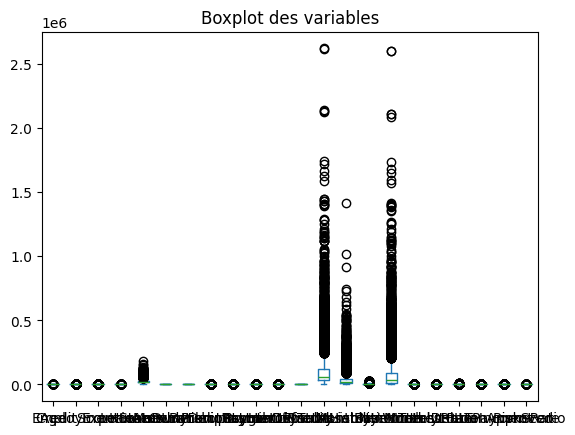

In [29]:
# ## Visualisation des Données
# Visualiser la distribution
# %%
df.plot.box()
plt.title("Boxplot des variables")
plt.show()

In [30]:
# ## Réduction des Caractéristiques
# Étape 1 : Calculer la matrice de corrélation
# %%
correlation_matrix = df.corr()

# Étape 2 : Identifier les colonnes à supprimer
threshold = 0.8  # Seuil de corrélation
to_drop = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            to_drop.add(colname)


# Supprimer les colonnes identifiées
print("Colonnes à supprimer en raison d'une forte corrélation:", to_drop)
df_reduced = df.drop(columns=to_drop)

# Afficher les colonnes restantes
print("Colonnes après réduction :", df_reduced.columns.tolist())

Colonnes à supprimer en raison d'une forte corrélation: {'InterestRate', 'NetWorth', 'Experience'}
Colonnes après réduction : ['Age', 'CreditScore', 'EmploymentStatus', 'LoanAmount', 'LoanDuration', 'HomeOwnershipStatus', 'MonthlyDebtPayments', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'BaseInterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved', 'RiskScore']


Accuracy (Classification): 0.871


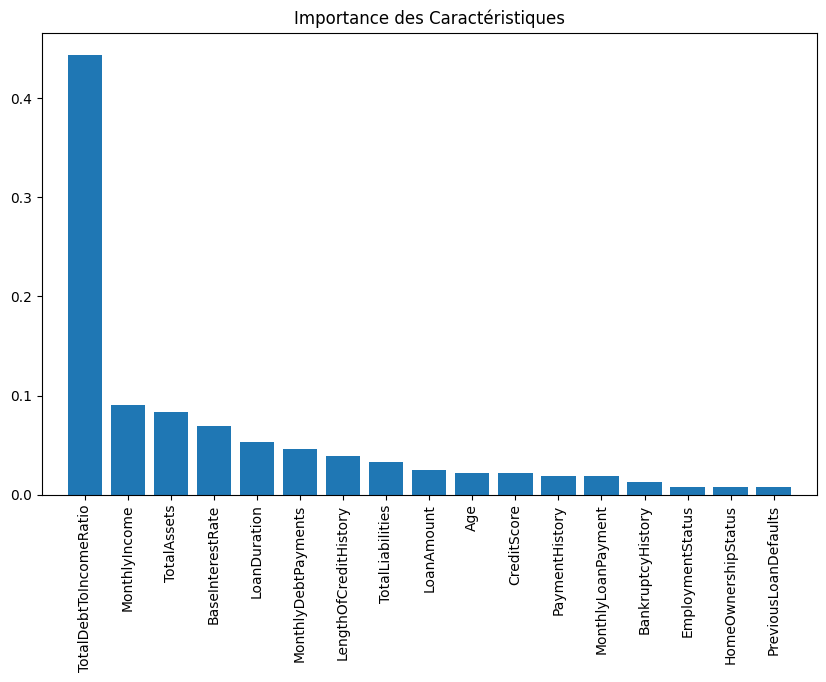

(Regression): 33.01521999999999
Modèles enregistrés avec succès.


In [34]:
# ## Modélisation
# Étape 1 : Séparer les caractéristiques (X) et les variables cibles (y)
# %%
X = df_reduced.drop(['LoanApproved', 'RiskScore'], axis=1)  # Caractéristiques
y_classification = df_reduced['LoanApproved']  # Variable cible pour la classification
y_regression = df_reduced['RiskScore']  # Variable cible pour la régression

# Étape 2 : Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_classification, test_size=0.2, random_state=42)
_, _, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.2, random_state=42)

# Étape 3 : Créer et entraîner l'arbre de décision pour la classification
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train_class)

# Étape 4 : Faire des prédictions sur l'ensemble de test pour la classification
y_pred_class = dt_classifier.predict(X_test)

# Étape 5 : Évaluer le modèle de classification
accuracy = accuracy_score(y_test_class, y_pred_class)
print("Accuracy (Classification):", accuracy)

# %% [markdown]
# ### Visualisation de l'Importance des Caractéristiques
# %%
# Visualiser l'importance des caractéristiques
feature_importances = dt_classifier.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Importance des Caractéristiques")
plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Étape 7 : Créer et entraîner l'arbre de décision pour la régression
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train_reg)

# Étape 8 : Faire des prédictions sur l'ensemble de test pour la régression
y_pred_reg = dt_regressor.predict(X_test)

# Étape 9 : Évaluer le modèle de régression
mse = mean_squared_error(y_test_reg, y_pred_reg)
print("(Regression):", mse)

# %% [markdown]
# ## Exportation des Résultats
# Exemple de données pour le test
# %%
data_test = {
    'Age': [28, 35, 45, 50, 23],
    'CreditScore': [720, 680, 750, 600, 790],
    'EmploymentStatus': [1, 0, 1, 0, 1],  # 1 = Employé, 0 = Chômeur
    'LoanAmount': [20000, 15000, 30000, 10000, 25000],
    'LoanDuration': [24, 36, 48, 12, 60],  # Durée en mois
    'HomeOwnershipStatus': [1, 0, 1, 0, 1],  # 1 = Propriétaire, 0 = Locataire
    'MonthlyDebtPayments': [500, 400, 700, 300, 600],
    'BankruptcyHistory': [0, 1, 0, 1, 0],  # 0 = Non, 1 = Oui
    'PreviousLoanDefaults': [0, 1, 0, 0, 1],  # 0 = Non, 1 = Oui
    'PaymentHistory': [1, 0, 1, 0, 1],  # 1 = Bon historique, 0 = Mauvais
    'PurposeOfLoan': [1, 0, 1, 0, 1],  # 1 = Personnel, 0 = Affaires
    'MonthlyIncome': [4000, 5000, 6000, 3000, 7000],
    'MonthlyLoanPayment': [400, 300, 500, 200, 600],
    'TotalAssets': [50000, 60000, 70000, 40000, 80000],
    
}

# Créer un DataFrame pour le test
df_test = pd.DataFrame(data_test)



# ## Sauvegarder les Modèles
# %%
joblib.dump(dt_classifier, 'model_filtered_classification.pkl')
joblib.dump(dt_regressor, 'regressor.pkl')
print("Modèles enregistrés avec succès.")